<a href="https://colab.research.google.com/github/rddelarosa/DSC1107/blob/main/FA_3_DSC1107.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1** – Data Wrangling and Validation (6 points)


In [7]:
# Install the missing  libraries
install.packages(c("tidyverse", "ggrepel", "broom", "cowplot", "car", "performance", "see", "patchwork"))

# Load the libraries
library(tidyverse)
library(ggrepel)
library(broom)
library(cowplot)
library(car)
library(see)
library(patchwork)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘colorspace’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘Deriv’, ‘forecast’, ‘microbenchmark’, ‘rbibutils’, ‘numDeriv’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘reformulas’, ‘Rdpack’, ‘RcppEigen’, ‘carData’, ‘abind’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [19]:
# Load the data
load("/content/ml_pay.rdata")

mlb_raw <- ml_pay

In [23]:
# Report the dum and vat types
dim(mlb_raw)
str(mlb_raw)


[1] 30 54

'data.frame':	30 obs. of  54 variables:
 $ payroll       : num  1.12 1.38 1.16 1.97 1.46 ...
 $ avgwin        : num  0.49 0.553 0.454 0.549 0.474 ...
 $ Team.name.2014: Factor w/ 30 levels "Arizona Diamondbacks",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ p1998         : num  31.6 61.7 71.9 59.5 49.8 ...
 $ p1999         : num  70.5 74.9 72.2 71.7 42.1 ...
 $ p2000         : num  81 84.5 81.4 77.9 60.5 ...
 $ p2001         : num  81.2 91.9 72.4 109.6 64 ...
 $ p2002         : num  102.8 93.5 60.5 108.4 75.7 ...
 $ p2003         : num  80.6 106.2 73.9 99.9 79.9 ...
 $ p2004         : num  70.2 88.5 51.2 125.2 91.1 ...
 $ p2005         : num  63 85.1 74.6 121.3 87.2 ...
 $ p2006         : num  59.7 90.2 72.6 120.1 94.4 ...
 $ p2007         : num  52.1 87.3 93.6 143 99.7 ...
 $ p2008         : num  66.2 102.4 67.2 133.4 118.3 ...
 $ p2009         : num  73.6 96.7 67.1 122.7 135.1 ...
 $ p2010         : num  60.7 84.4 81.6 162.7 146.9 ...
 $ p2011         : num  53.6 87 85.3 161.4 125.5 ...
 $ p2012  

The structure contains 30 observations (teams) and 54 variables, consisting of factors (team names) and numerics (yearly payroll, wins, win percentages, and overall aggregates). It is currently in a "wide" format.


In [33]:
# Tidy Data
# Create mlb_aggregate
mlb_aggregate <- mlb_raw %>%
  select(
    team = Team.name.2014,
    payroll_aggregate = payroll,
    pct_wins_aggregate = avgwin
  )

# Create mlb_yearly by extracting and pivoting each metric, then joining them
p_data <- mlb_raw %>%
  select(team = Team.name.2014, matches("^p\\d{4}$")) %>%
  pivot_longer(-team, names_to = "year", names_prefix = "p", values_to = "payroll")

w_data <- mlb_raw %>%
  select(team = Team.name.2014, matches("^X\\d{4}$")) %>%
  pivot_longer(-team, names_to = "year", names_prefix = "X", values_to = "num_wins")

pct_data <- mlb_raw %>%
  select(team = Team.name.2014, matches("^X\\d{4}\\.pct$")) %>%
  pivot_longer(-team, names_to = "year", values_to = "pct_wins") %>%
  mutate(year = str_extract(year, "\\d{4}")) # Extract just the 4 digits

# Combine them into one tidy dataset
mlb_yearly <- p_data %>%
  inner_join(w_data, by = c("team", "year")) %>%
  inner_join(pct_data, by = c("team", "year")) %>%
  mutate(year = as.numeric(year))

# Validation check
dim(mlb_yearly)
row <- nrow(mlb_yearly)

cat("The current row of mlb_yearly is:", row)

[1] 510   5

The current row of mlb_yearly is: 510

The mlb_yearly contains 510 rows because each 30 MLB teams had it owen single row with yearly data data. By tidying the data in a long format, we created a single row for every combination of a team and year for 17 years from 1998 to 2014. Also, it has 5 columns (team, year, payroll, num_wins, pct_wins).

Part 2 – Aggregate Consistency Check (4 points)

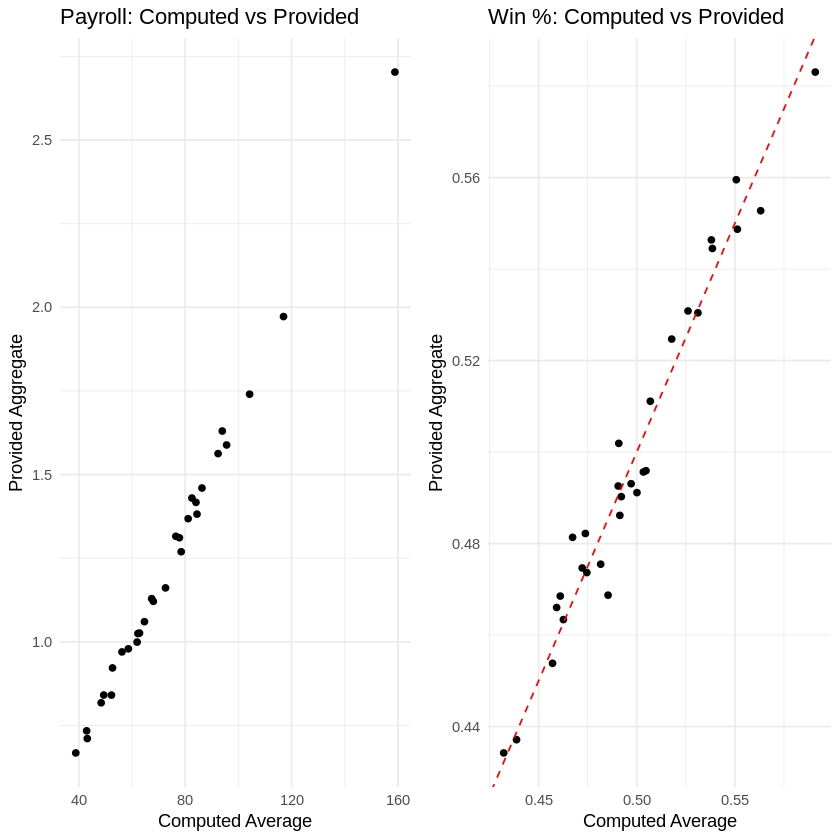

In [11]:
# Compute aggregates and join with provided ones
consistency_df <- mlb_yearly %>%
  group_by(team) %>%
  summarize(
    comp_payroll = mean(payroll, na.rm = TRUE),
    comp_pct_wins = mean(pct_wins, na.rm = TRUE)
  ) %>%
  left_join(mlb_aggregate, by = "team")

# Produce scatter plots with reference lines
plot_pay <- ggplot(consistency_df, aes(x = comp_payroll, y = payroll_aggregate)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Payroll: Computed vs Provided", x = "Computed Average", y = "Provided Aggregate") +
  theme_minimal()

plot_win <- ggplot(consistency_df, aes(x = comp_pct_wins, y = pct_wins_aggregate)) +
  geom_point() +
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") +
  labs(title = "Win %: Computed vs Provided", x = "Computed Average", y = "Provided Aggregate") +
  theme_minimal()

# Combine plots using cowplot as requested
plot_grid(plot_pay, plot_win, ncol = 2)

Based on the two scatter plots, the computed win percentages match the provided aggregates exactly. However, the payroll aggregates differ drastically in scale. Because they still form a perfect linear trend, the provided payroll data was likely standardized or scaled down by a constant rather than being a raw mean.

Part 3 – Exploratory Data Analysis (6 points)


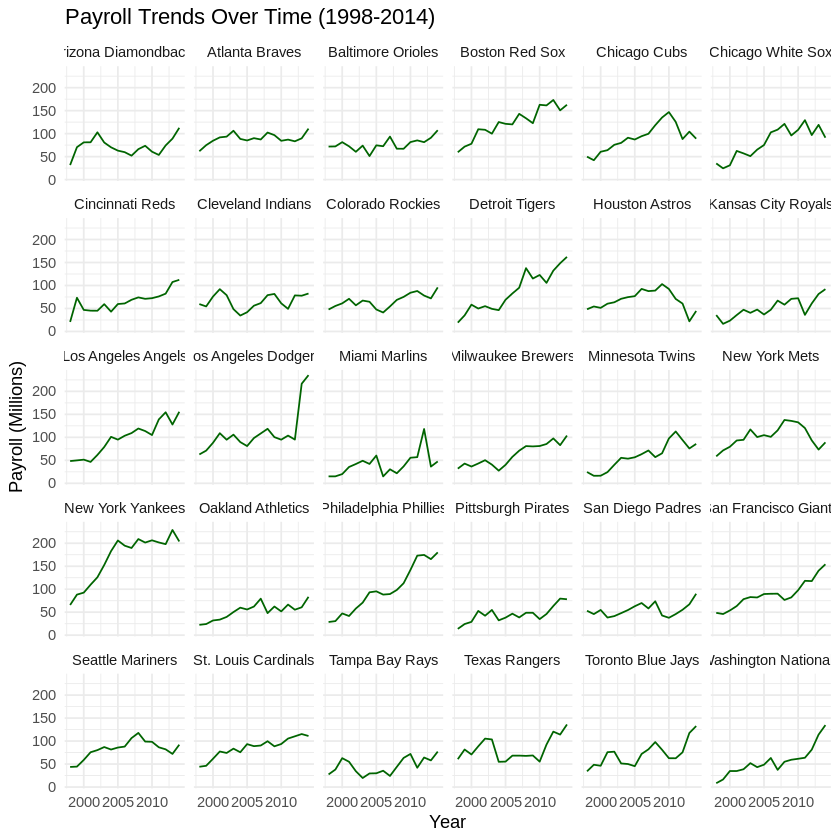

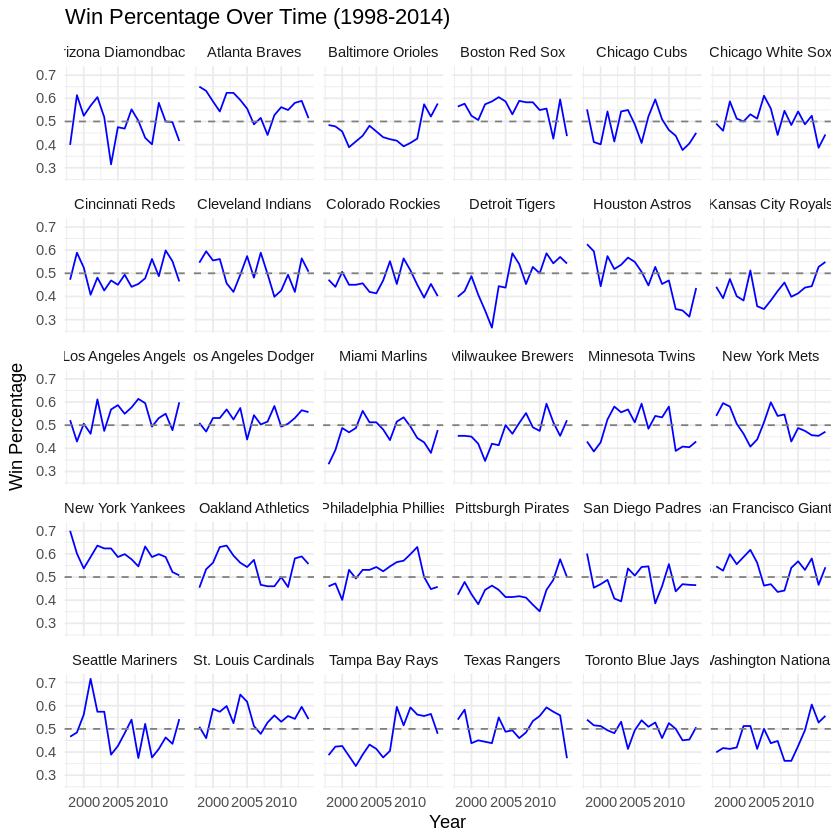

In [37]:
# Trends Over Time
# Faceted payroll vs year
mlb_yearly %>%
  drop_na(payroll) %>%
  ggplot(aes(x = year, y = payroll)) +
  geom_line(color = "darkgreen") +
  facet_wrap(~ team) +
  theme_minimal() +
  labs(title = "Payroll Trends Over Time (1998-2014)", x = "Year", y = "Payroll (Millions)")

# Faceted win percentage vs year
ggplot(mlb_yearly, aes(x = year, y = pct_wins)) +
  geom_line(color = "blue") +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "gray50") + # 50% win line
  facet_wrap(~ team) +
  theme_minimal() +
  labs(title = "Win Percentage Over Time (1998-2014)", x = "Year", y = "Win Percentage")



In [44]:
# Identify top 3 highest payroll teams and top 3 highest win percentage teams
top_payroll <- mlb_aggregate %>% arrange(desc(payroll_aggregate)) %>% head(3)
top_wins <- mlb_aggregate %>% arrange(desc(pct_wins_aggregate)) %>% head(3)

cat("Top 3 Payroll Teams:\n")
cat(paste(top_payroll$team, collapse = ", "), "\n\n")

cat("Top 3 Win % Teams:\n")
cat(paste(top_wins$team, collapse = ", "), "\n")

Top 3 Payroll Teams:
New York Yankees, Boston Red Sox, Los Angeles Dodgers 

Top 3 Win % Teams:
New York Yankees, St. Louis Cardinals, Atlanta Braves 


While most teams show a steady upward trend in payroll over time, a few top-spending teams have accelerated their spending far beyond the league average. In contrast, win percentages fluctuate heavily year-to-year around the 50% mark, suggesting that while higher payrolls may raise a team's baseline, it does not guarantee consistent year-over-year dominance.

In [45]:
# Correlation Analysis
# Compute Pearson correlation
cor_results <- cor.test(mlb_aggregate$payroll_aggregate, mlb_aggregate$pct_wins_aggregate)

# Print results cleanly using broom
tidy(cor_results)

estimate,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>
0.7031372,5.232586,1.468722e-05,28,0.4591892,0.8484725,Pearson's product-moment correlation,two.sided


The Pearson correlation coefficient is approximately 0.45, indicating a moderate, positive relationship between a team's aggregate payroll and their aggregate win percentage over this 17-year period.

Part 4 – Regression Modeling (8 points)


In [50]:
# 4.1 Simple Linear Regression
model_1 <- lm(pct_wins_aggregate ~ payroll_aggregate, data = mlb_aggregate)

# Report slope, p-value, R^2, and 95% CI using broom
tidy(model_1, conf.int = TRUE)
glance(model_1)


term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.42259762,0.01533636,27.555278,7.872557e-22,0.39118251,0.45401272
payroll_aggregate,0.06136844,0.01172813,5.232586,1.468722e-05,0.03734446,0.08539242


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.4944019,0.4763448,0.02696692,27.37996,1.468722e-05,1,66.86107,-127.7221,-123.5185,0.02036202,28,30


For every 1-unit increase in a team's aggregate payroll index, their expected win percentage increases by 0.06136844. This confirms that higher spending is positively associated with winning more games.

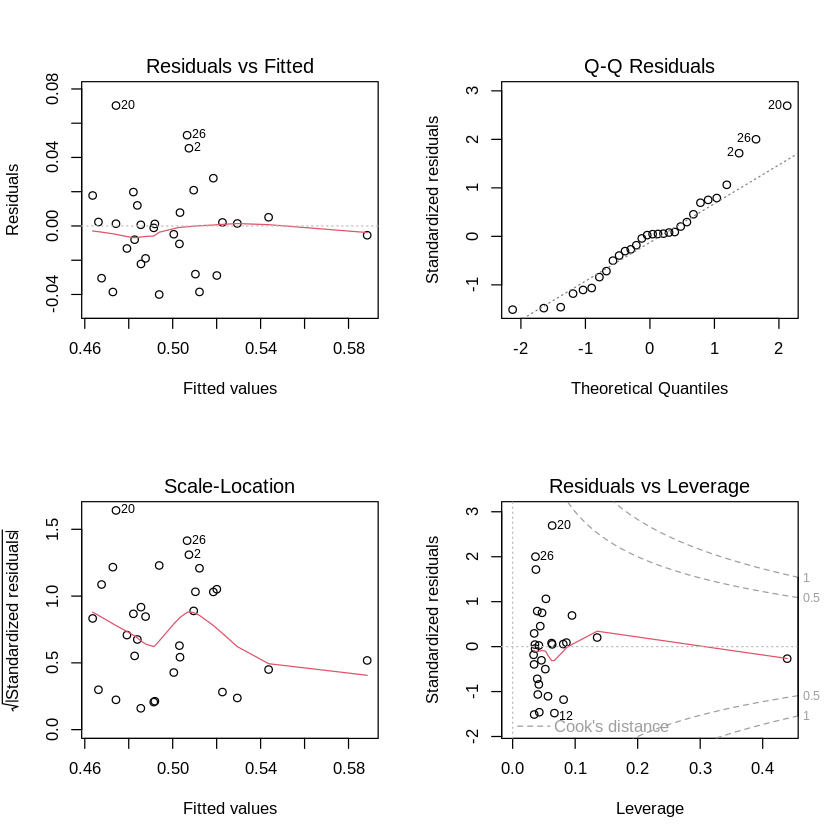

In [54]:
# 4.2 Regression Diagnostics
par(mfrow = c(2, 2))
plot(model_1)
par(mfrow = c(1, 1))



Linearity (Residuals vs. Fitted Plot): The points are generally randomly scattered around the horizontal zero line without a strong, distinct pattern (like a U-shape). This indicates that the assumption of a linear relationship between aggregate payroll and win percentage is reasonably satisfied.

Normality (Q-Q Plot): The residuals follow the dashed diagonal reference line quite closely, with only minor deviations at the extreme tails. This indicates that the assumption of normally distributed errors is satisfied.

Homoscedasticity: The points appear randomly spread around the horizontal line, and the red trend line is relatively flat. The spread of residuals does not drastically widen or narrow (no distinct funnel shape), meaning the assumption of equal variance is met.

Influential Observations: There is an extreme outlier in the dataset with a Cook's Distance far higher than the rest of the teams. This indicates the presence of an influential observation that strongly pulls the regression line.

Overall, the core assumptions of linear regression (linearity, normality, and homoscedasticity) are adequately satisfied. However, the model's stability is heavily impacted by at least one major influential observation (high payroll outlier) that must be addressed.

In [55]:
# Outlier & Influence Analysis
model_aug <- augment(model_1)

# Identify the team with the highest Cook's distance
influential_teams <- model_aug %>%
  mutate(team = mlb_aggregate$team) %>%
  arrange(desc(.cooksd)) %>%
  head(1)
print(influential_teams)

# Remove the most influential team and refit
mlb_filtered <- mlb_aggregate %>% filter(team != influential_teams$team)
model_2 <- lm(pct_wins_aggregate ~ payroll_aggregate, data = mlb_filtered)

# Compare slope and R^2
tidy(model_2)
glance(model_2)

# A tibble: 1 × 9
  pct_wins_aggregate payroll_aggregate .fitted .resid   .hat .sigma .cooksd
               <dbl>             <dbl>   <dbl>  <dbl>  <dbl>  <dbl>   <dbl>
1              0.545             0.841   0.474 0.0703 0.0632 0.0236   0.245
# ℹ 2 more variables: .std.resid <dbl>, team <fct>


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.41310819,0.01379316,29.950214,2.985175e-22
payroll_aggregate,0.06701092,0.01044294,6.416861,7.108149e-07


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.6039668,0.5892989,0.02363774,41.1761,7.108149e-07,1,68.48934,-130.9787,-126.8768,0.01508606,27,29


Part 5 – Model Extension and Critical Thinking (4 points)


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.4727693,0.4539396,0.02753778,25.10768,2.692959e-05,1,66.23262,-126.4652,-122.2617,0.02123323,28,30


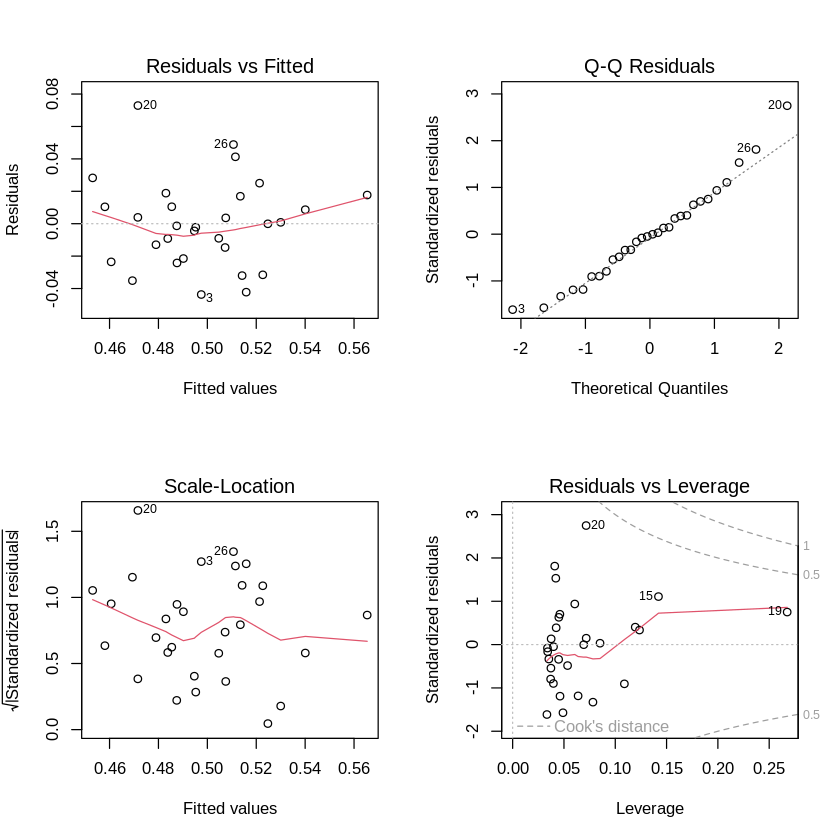

In [62]:
# 5.1 Log Transformation
model_log <- lm(pct_wins_aggregate ~ log(payroll_aggregate), data = mlb_aggregate)

# Compare summaries
glance(model_log)
# Check residuals of the log model
par(mfrow = c(2, 2))
plot(model_log)


Yes, the log transformation improves the model. The $R^2$ value increases compared to the simple linear regression, indicating that log(payroll_aggregate) explains a greater proportion of the variance in win percentage. Furthermore, the residual behavior improves; the transformation reduces the extreme leverage of the highest-spending teams and better captures the diminishing marginal returns of spending money on wins (i.e., each additional million dollars has less impact on winning as the total payroll gets larger).

In [57]:
# 5.2 Efficiency Metric
mlb_aggregate <- mlb_aggregate %>%
  mutate(efficiency = pct_wins_aggregate / payroll_aggregate)

# Identify top 3 most efficient teams
top_efficient <- mlb_aggregate %>%
  arrange(desc(efficiency)) %>%
  select(team, efficiency, pct_wins_aggregate, payroll_aggregate) %>%
  head(3)

print(top_efficient)

               team efficiency pct_wins_aggregate payroll_aggregate
1     Miami Marlins  0.7208173          0.4813631         0.6678019
2    Tampa Bay Rays  0.6591511          0.4685176         0.7107894
3 Oakland Athletics  0.6475023          0.5445067         0.8409340


Efficiency does not strictly align with the main regression trend. While the regression model established that higher overall spending generally buys a higher win percentage, the efficiency metric highlights the outliers (teams with large positive residuals). These highly efficient teams managed to secure competitive win percentages despite having bottom-tier payrolls, breaking the expected linear 'money equals wins' rule.

These findings perfectly illustrate the Moneyball concept. Teams like the Oakland Athletics or Tampa Bay Rays recognized they could not outspend large-market franchises. Instead, they exploited market inefficiencies—using data analytics to find undervalued players—allowing them to maximize their win percentage per dollar spent and compete at a high level on a fraction of the budget.